In [ ]:
# %%

# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score
import plotly.graph_objects as go

##########################################
def normalize_and_sort_by_admission_date(df1, df2):
    """
    Normalize the date column and then sort the provided DataFrames by the given date column.
    
    Parameters:
    df1 (pd.DataFrame): The first DataFrame to normalize and sort.
    df2 (pd.DataFrame): The second DataFrame to normalize and sort.
    
    Returns:
    pd.DataFrame, pd.DataFrame: The normalized and sorted DataFrames.
    """
    # Normalize the date columns in both DataFrames
    df1["Admission_Entry_Date"] = pd.to_datetime(df1["Admission_Entry_Date"]).dt.date
    df2["Admission_Entry_Date"] = pd.to_datetime(df2["Admission_Entry_Date"]).dt.date
    
    # Sort both DataFrames by the normalized date column
    sorted_df1 = df1.sort_values(by="Admission_Entry_Date")
    sorted_df2 = df2.sort_values(by="Admission_Entry_Date")
    
    return sorted_df1, sorted_df2

# Define the updated model_kpi function
def model_kpi(y_true, y_pred):
    # Calculate the confusion matrix
    confusion_mtx = confusion_matrix(y_true, y_pred)
    
    # Calculating metrics for multi-class classification
    precision = precision_score(y_true, y_pred, average='weighted',zero_division=1)
    recall = recall_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    # Creating a dictionary of the metrics
    metrics_dict = {
        'Precision': precision,
        'Recall': recall,
        'Accuracy': accuracy,
        'Balanced Accuracy': balanced_accuracy,
        'F1 Score': f1
    }
    
    # Converting the dictionary to a pandas DataFrame
    metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index', columns=['Value'])
    return metrics_df, confusion_mtx

# Define the updated confusion_table function for multi-class classification
def confusion_table(confusion_mtx, class_labels):
    """
    Creates a confusion table for multi-class classification with the given labels.

    Parameters:
    confusion_mtx (array): The confusion matrix
    class_labels (list): List of class labels

    Returns:
    pd.DataFrame: A DataFrame styled as a confusion table
    """
    # Create the confusion table with labels
    confusion_df = pd.DataFrame(confusion_mtx, index=[f'Actual {label}' for label in class_labels],
                                columns=[f'Predicted {label}' for label in class_labels])

    # Add totals
    confusion_df['Total'] = confusion_df.sum(axis=1)
    confusion_df.loc['Total'] = confusion_df.sum(axis=0)
    
    return confusion_df

# Load the specific sheets to understand their content
file_path = "F:\\לימודים\\תואר שני\\סמסטר ב\\Data Science 2\\DS2-Final Project\\rehospitalization.xlsx"
units_occupancy_rate = pd.read_excel(file_path, sheet_name='unitsOccupancyRate')
hospitalization1 = pd.read_excel(file_path, sheet_name='hospitalization1')
hospitalization2 = pd.read_excel(file_path, sheet_name='hospitalization2')

## Data Preprocessing and Exploration
In this section, we load the hospitalization and occupancy rate data and translate relevant columns to English for easier processing. The dates are normalized, and we categorize hospitalizations based on the number of days between release dates. We then visualize the distribution of hospitalization durations and occupancy rates to explore any apparent patterns.

In [ ]:
# %% 

# Translate column names to English
column_translation = {
    "תאריך": "Date",
    "מחלקה": "Department",
    "כמות שוהים": "Occupancy",
    "שיעור תפוסה": "Occupancy Rate",
    # Add all other columns that need to be translated
}

units_occupancy_rate.rename(columns=column_translation, inplace=True)
units_occupancy_rate["Date"] = pd.to_datetime(units_occupancy_rate["Date"]).dt.date
units_occupancy_rate.head()

,Date,Department,Occupancy,Occupancy Rate
0,2020-01-01,4,31,0.775
1,2020-01-01,2,30,0.750
2,2020-01-01,5,40,1.000
3,2020-01-01,1,32,0.800
4,2020-01-01,3,37,0.925


In [ ]:
# %%

############################
print("hospitalization1")
display(hospitalization1.head(5))
print("hospitalization2")
display(hospitalization2.head(5))
print("units_occupancy_rate")
display(units_occupancy_rate.head(5))
############################

hospitalization1


,Patient,unitName1,Admission_Medical_Record,Admission_Entry_Date,Release_Date,סוג קבלה,מהיכן המטופל הגיע,Release_Type,רופא משחרר-קוד,ימי אשפוז,אבחנות בקבלה,אבחנות בשחרור
0,62051,1,5207766,2021-09-04 22:21:04.440,2021-09-08 14:43:00,דחוף,מביתו,שוחרר לביתו,6878.0,4,42731,42731
1,951769,2,5605505,2022-02-15 14:39:02.220,2022-02-16 13:37:00,דחוף,אחר,שוחרר לביתו,12615.0,1,Z3601,Z3601
2,863707,2,6755794,2023-05-15 04:21:09.137,2023-05-15 15:59:00,דחוף,מביתו,שוחרר לביתו,12599.0,0,7895,7895
3,884200,3,6964052,2023-07-27 08:16:48.640,2023-07-28 17:34:00,דחוף,ממוסד,שוחרר לביתו,11582.0,1,78609,"4919 , 78609"
4,936226,4,7023187,2023-08-20 19:44:35.410,2023-08-21 15:47:00,דחוף,מביתו,שוחרר לביתו,12359.0,1,78609,"78609 , 81203 , 83100"


hospitalization2


,Patient,unitName1,Admission_Medical_Record,Admission_Entry_Date,Release_Date,unitName2,Admission_Medical_Record2,Admission_Entry_Date2,Release_Date2,סוג קבלה,מהיכן המטופל הגיע,Release_Type,רופא משחרר,ימי אשפוז,אבחנות בקבלה,אבחנות בשחרור,מחלקות מייעצות,ct
0,430047,5,4727327,2021-02-16 17:33:45.570,2021-02-19 12:40:00,5,4745943,2021-02-24 15:03:30.490,2021-02-25 12:38:00,דחוף,מביתו,שוחרר לביתו,11023.0,1,"5370 , 7872 , 78720","5370 , 7872 , 78720",NaN,0
1,447962,4,6084166,2022-08-07 13:27:58.780,2022-08-08 15:15:00,4,6137129,2022-09-01 04:20:51.617,2022-09-02 16:00:00,דחוף,מביתו,שוחרר לביתו,12517.0,1,78060,78060,ריפוי בעיסוק,0
2,214558,5,7164813,2023-10-27 07:34:41.013,2023-10-29 17:18:00,5,7172678,2023-10-30 17:58:09.730,2023-11-01 15:33:00,דחוף,מביתו,שוחרר לביתו,11887.0,2,5119,"5119 , 514",שירות דיאטה,0
3,71277,3,4295329,2020-07-29 17:00:56.863,2020-08-03 14:26:00,3,4354333,2020-08-30 04:25:30.670,2020-09-03 13:45:00,דחוף,מביתו,שוחרר לביתו,10525.0,4,"2859 , 7807","486 , 5990",".שרות לפיזיותרפיה , מערך אורתופדי",0
4,112016,1,5052676,2021-07-03 11:42:24.973,2021-07-05 17:34:00,1,5078317,2021-07-13 01:21:32.077,2021-07-15 11:48:00,דחוף,מביתו,שוחרר לביתו,6890.0,2,7865,7865,"קרדיולוגיה- יעוצים , שירות דיאטה",1


units_occupancy_rate


,Date,Department,Occupancy,Occupancy Rate
0,2020-01-01,4,31,0.775
1,2020-01-01,2,30,0.750
2,2020-01-01,5,40,1.000
3,2020-01-01,1,32,0.800
4,2020-01-01,3,37,0.925


In [ ]:
# %%

# Normalize the dates to be only the date without time
hospitalization2['Admission_Entry_Date'] = pd.to_datetime(hospitalization2['Admission_Entry_Date']).dt.date
hospitalization2['Release_Date'] = pd.to_datetime(hospitalization2['Release_Date']).dt.date
hospitalization2['Admission_Entry_Date2'] = pd.to_datetime(hospitalization2['Admission_Entry_Date2']).dt.date
hospitalization2['Release_Date2'] = pd.to_datetime(hospitalization2['Release_Date2']).dt.date

# Calculate the days between Release_Date and Admission_Entry_Date2
hospitalization2['Days_Between'] = (pd.to_datetime(hospitalization2['Admission_Entry_Date2']) - pd.to_datetime(hospitalization2['Release_Date'])).dt.days

# Categorize the Days_Between into 'Short', 'Medium', 'Long'
hospitalization2['Duration_Category'] = pd.cut(hospitalization2['Days_Between'], bins=[-1, 10, 20, 30], labels=['Short', 'Medium', 'Long'])

In [ ]:
# %%

# Display the updated dataframe with the new category column
hospitalization2.head()

,Patient,unitName1,Admission_Medical_Record,Admission_Entry_Date,Release_Date,unitName2,Admission_Medical_Record2,Admission_Entry_Date2,Release_Date2,סוג קבלה,מהיכן המטופל הגיע,Release_Type,רופא משחרר,ימי אשפוז,אבחנות בקבלה,אבחנות בשחרור,מחלקות מייעצות,ct,Days_Between,Duration_Category
0,430047,5,4727327,2021-02-16,2021-02-19,5,4745943,2021-02-24,2021-02-25,דחוף,מביתו,שוחרר לביתו,11023.0,1,"5370 , 7872 , 78720","5370 , 7872 , 78720",NaN,0,5,Short
1,447962,4,6084166,2022-08-07,2022-08-08,4,6137129,2022-09-01,2022-09-02,דחוף,מביתו,שוחרר לביתו,12517.0,1,78060,78060,ריפוי בעיסוק,0,24,Long
2,214558,5,7164813,2023-10-27,2023-10-29,5,7172678,2023-10-30,2023-11-01,דחוף,מביתו,שוחרר לביתו,11887.0,2,5119,"5119 , 514",שירות דיאטה,0,1,Short
3,71277,3,4295329,2020-07-29,2020-08-03,3,4354333,2020-08-30,2020-09-03,דחוף,מביתו,שוחרר לביתו,10525.0,4,"2859 , 7807","486 , 5990",".שרות לפיזיותרפיה , מערך אורתופדי",0,27,Long
4,112016,1,5052676,2021-07-03,2021-07-05,1,5078317,2021-07-13,2021-07-15,דחוף,מביתו,שוחרר לביתו,6890.0,2,7865,7865,"קרדיולוגיה- יעוצים , שירות דיאטה",1,8,Short


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


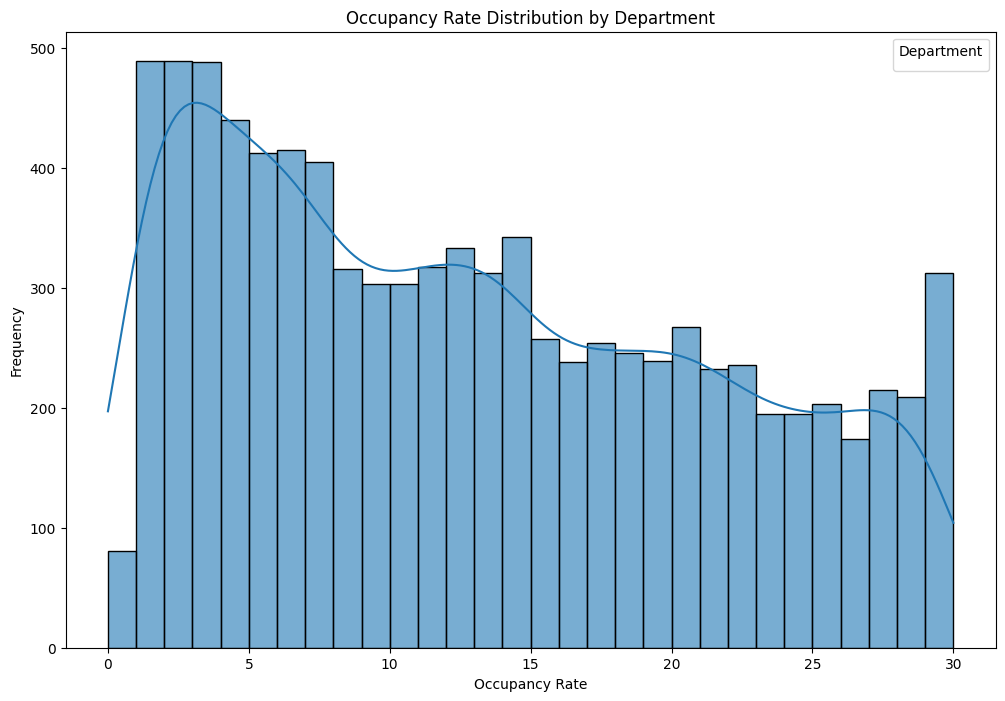

In [ ]:
# %% 

plt.figure(figsize=(12, 8))
sns.histplot(hospitalization2["Days_Between"], kde=True, bins=30, alpha=0.6)
plt.title("Occupancy Rate Distribution by Department")
plt.xlabel("Occupancy Rate")
plt.ylabel("Frequency")
plt.legend(title="Department")
plt.show()

In [ ]:
# %%

def get_occupancy_rate(date, department, units_occupancy_rate):
    """
    Retrieve the Occupancy Rate for a given date and department.

    Parameters:
    date (str or pd.Timestamp): The date for which to retrieve the Occupancy Rate.
    department (str or int): The department for which to retrieve the Occupancy Rate.
    units_occupancy_rate (pd.DataFrame): The DataFrame containing occupancy rate data.

    Returns:
    float: The Occupancy Rate for the given date and department, or None if not found.
    """
    # Convert date to datetime if it's not already
    date = pd.to_datetime(date).date()
    
    # Convert department to string and strip any leading/trailing spaces
    department = str(department).strip()

    # Filter the DataFrame for the matching date and department
    result = units_occupancy_rate[(units_occupancy_rate['Date'] == date) & 
                                  (units_occupancy_rate['Department'].astype(str).str.strip() == department)]

    # Return the Occupancy Rate if found, otherwise return None
    if not result.empty:
        return result['Occupancy Rate'].values[0]
    else:
        return None

In [ ]:
# %% 

rate = get_occupancy_rate("2022-01-25", 4, units_occupancy_rate)
display(rate)

0.625

In [ ]:
# %%

# Add a new column 'Unit_Occupancy_Rate_ReleaseDate' by applying the get_occupancy_rate function
hospitalization2['Unit_Occupancy_Rate_ReleaseDate'] = hospitalization2.apply(
    lambda row: get_occupancy_rate(row['Release_Date'], row['unitName1'], units_occupancy_rate), axis=1
)

# Display the updated DataFrame with the new column
display(hospitalization2[['Release_Date', 'unitName1', 'Unit_Occupancy_Rate_ReleaseDate']].head())

# Check for Null Values
hospitalization2.Unit_Occupancy_Rate_ReleaseDate.isnull().sum()

# Identify all rows (indexes) that contain any NaN values
nan_indexes = hospitalization2[hospitalization2['Unit_Occupancy_Rate_ReleaseDate'].isna()].index
print("Indexes with NaN values:", nan_indexes.tolist())

# Drop the rows with NaN values from the hospitalization2 DataFrame
hospitalization2_cleaned = hospitalization2.drop(index=nan_indexes)

# Display the cleaned DataFrame to verify that the rows were removed
display(hospitalization2_cleaned.head())

,Release_Date,unitName1,Unit_Occupancy_Rate_ReleaseDate
0,2021-02-19,5,0.800
1,2022-08-08,4,0.675
2,2023-10-29,5,0.850
3,2020-08-03,3,0.975
4,2021-07-05,1,0.850


Indexes with NaN values: [466, 1275, 2187, 2528, 2774, 3369, 3428, 3448, 4637, 5667, 6147, 6570, 7510, 7601, 7873, 8286, 8537, 8585, 8642, 8700]


,Patient,unitName1,Admission_Medical_Record,Admission_Entry_Date,Release_Date,unitName2,Admission_Medical_Record2,Admission_Entry_Date2,Release_Date2,סוג קבלה,...,Release_Type,רופא משחרר,ימי אשפוז,אבחנות בקבלה,אבחנות בשחרור,מחלקות מייעצות,ct,Days_Between,Duration_Category,Unit_Occupancy_Rate_ReleaseDate
0,430047,5,4727327,2021-02-16,2021-02-19,5,4745943,2021-02-24,2021-02-25,דחוף,...,שוחרר לביתו,11023.0,1,"5370 , 7872 , 78720","5370 , 7872 , 78720",NaN,0,5,Short,0.800
1,447962,4,6084166,2022-08-07,2022-08-08,4,6137129,2022-09-01,2022-09-02,דחוף,...,שוחרר לביתו,12517.0,1,78060,78060,ריפוי בעיסוק,0,24,Long,0.675
2,214558,5,7164813,2023-10-27,2023-10-29,5,7172678,2023-10-30,2023-11-01,דחוף,...,שוחרר לביתו,11887.0,2,5119,"5119 , 514",שירות דיאטה,0,1,Short,0.850
3,71277,3,4295329,2020-07-29,2020-08-03,3,4354333,2020-08-30,2020-09-03,דחוף,...,שוחרר לביתו,10525.0,4,"2859 , 7807","486 , 5990",".שרות לפיזיותרפיה , מערך אורתופדי",0,27,Long,0.975
4,112016,1,5052676,2021-07-03,2021-07-05,1,5078317,2021-07-13,2021-07-15,דחוף,...,שוחרר לביתו,6890.0,2,7865,7865,"קרדיולוגיה- יעוצים , שירות דיאטה",1,8,Short,0.850


## Model Building and Hyperparameter Tuning
Here, we apply various machine learning models, including Logistic Regression, Random Forest, K-Nearest Neighbors (KNN), and Support Vector Machines (SVM). We also introduce a neural network with added layers and class weights to handle imbalanced data. GridSearchCV is used to find the optimal hyperparameters for the traditional machine learning models, and the neural network is trained with early stopping to avoid overfitting.

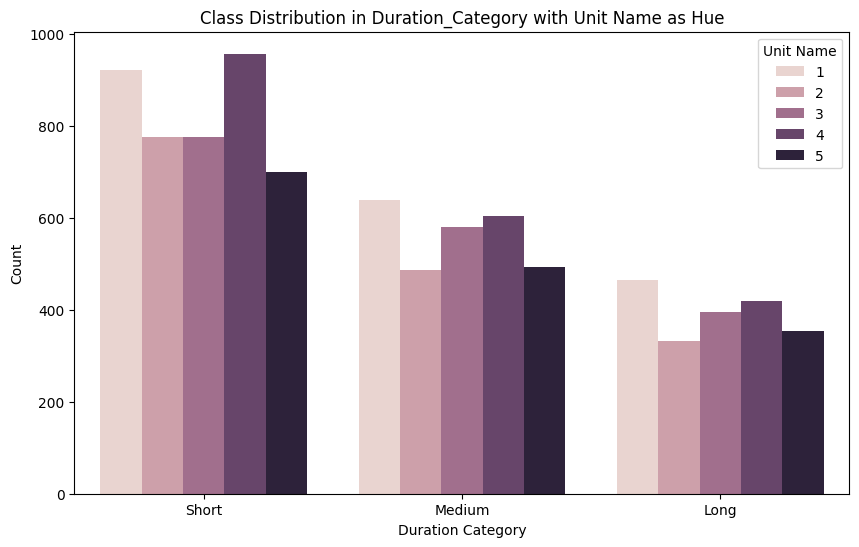

In [ ]:
# %% 

# Create a countplot with Duration_Category and hue based on unitName1
plt.figure(figsize=(10, 6))
sns.countplot(data=hospitalization2_cleaned, x='Duration_Category', hue='unitName1')
plt.title('Class Distribution in Duration_Category with Unit Name as Hue')
plt.xlabel('Duration Category')
plt.ylabel('Count')
plt.legend(title='Unit Name')
plt.show()

In [ ]:
# %% Model Comparison with GridSearchCV, Cross-Validation, and Neural Network

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from IPython.display import display, HTML
import numpy as np

# Prepare the data for modeling
X = hospitalization2_cleaned[['Unit_Occupancy_Rate_ReleaseDate']]  # Feature: occupancy rate at release date
y = hospitalization2_cleaned['Duration_Category']  # Target: Duration category (Short, Medium, Long)

# Define the class labels for the Duration Category
class_labels = ['Short', 'Medium', 'Long']

# Convert the categorical target variable to numeric codes
y_encoded = y.cat.codes

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Standardize the feature
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Calculate class weights to handle imbalanced classes
unique_classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(unique_classes))}
print(f"Class Weights: {class_weights_dict}")

# Function to perform GridSearchCV
def perform_grid_search(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.best_params_

# Logistic Regression
logistic_model = LogisticRegression(multi_class='ovr', solver='liblinear', class_weight='balanced')
param_grid_log = {'C': [0.1, 1, 10, 100]}  # Example hyperparameter
logistic_best_model, logistic_best_params = perform_grid_search(logistic_model, param_grid_log, X_train_scaled, y_train)

# Random Forest
random_forest_model = RandomForestClassifier(class_weight='balanced', random_state=42)
param_grid_rf = {'n_estimators': [100, 200, 300], 'max_depth': [10, 20, 30]}  # Example hyperparameter grid
rf_best_model, rf_best_params = perform_grid_search(random_forest_model, param_grid_rf, X_train_scaled, y_train)

# K-Nearest Neighbors (KNN)
knn_model = KNeighborsClassifier()
param_grid_knn = {'n_neighbors': [5, 10, 20]}  # Example hyperparameter grid
knn_best_model, knn_best_params = perform_grid_search(knn_model, param_grid_knn, X_train_scaled, y_train)

# Support Vector Machine (SVM)
svm_model = SVC(class_weight='balanced', random_state=42)
param_grid_svm = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}  # Example hyperparameter grid
svm_best_model, svm_best_params = perform_grid_search(svm_model, param_grid_svm, X_train_scaled, y_train)

# Improved Deep Learning Model (Feed-forward Neural Network)
def build_improved_neural_network():
    model = Sequential()
    
    # Adding more layers and neurons for better capacity
    model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    
    # Output layer with 3 classes (Softmax for classification)
    model.add(Dense(3, activation='softmax'))
    
    # Compile the model with a lower learning rate
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Create the improved neural network model
improved_neural_model = build_improved_neural_network()

# Callbacks: EarlyStopping and ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# If the shape of y_train or y_test is incorrect, reshape it to a one-dimensional array
y_train = y_train.ravel()
y_test = y_test.ravel()


# Train the improved neural network model with class weights
history = improved_neural_model.fit(
    X_train_scaled,
    y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=100,
    batch_size=32,
    class_weight=class_weights_dict,  # Apply class weights to handle imbalance
    callbacks=[early_stopping, reduce_lr],  # Apply early stopping and learning rate scheduler
    verbose=1
)

# Fit the best models to the test set and evaluate each one
models = {
    'Logistic Regression': logistic_best_model,
    'Random Forest': rf_best_model,
    'KNN': knn_best_model,
    'SVM': svm_best_model,
    'Neural Network': improved_neural_model
}

# Function to display KPI results for each model
def display_kpi_results(model_name, model, X_test_scaled, y_test):
    if model_name == 'Neural Network':
        # Predict for the neural network
        y_pred = model.predict(X_test_scaled).argmax(axis=1)
    else:
        # Predict for the traditional models
        y_pred = model.predict(X_test_scaled)
    
    # Get the KPI metrics and confusion matrix
    kpi_df, confusion_mtx = model_kpi(y_test, y_pred)
    
    # Display the confusion matrix and KPI
    display(HTML(f'<h2>{model_name} Confusion Matrix</h2>'))
    display(confusion_table(confusion_mtx, class_labels))
    display(HTML(f'<h2>{model_name} Model KPI</h2>'))
    display(kpi_df)

# Evaluate each model and display the results
for model_name, model in models.items():
    if model_name != 'Neural Network':
        model.fit(X_train_scaled, y_train)
    display_kpi_results(model_name, model, X_test_scaled, y_test)

Class Weights: {0: 0.7184534625479507, 1: 1.053433984606276, 2: 1.5178076348901686}
Epoch 1/100


f:\לימודים\תואר שני\סמסטר ב\Data Science 2\DS2-Final Project\data-science2-lab-final-project\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3010 - loss: 1.1041 - val_accuracy: 0.3955 - val_loss: 1.0955 - learning_rate: 0.0010
Epoch 2/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - accuracy: 0.3642 - loss: 1.1048 - val_accuracy: 0.4039 - val_loss: 1.0993 - learning_rate: 0.0010
Epoch 3/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - accuracy: 0.4465 - loss: 1.0871 - val_accuracy: 0.3011 - val_loss: 1.1036 - learning_rate: 0.0010
Epoch 4/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - accuracy: 0.3339 - loss: 1.0987 - val_accuracy: 0.3865 - val_loss: 1.1012 - learning_rate: 0.0010
Epoch 5/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - accuracy: 0.4344 - loss: 1.0932 - val_accuracy: 0.3865 - val_loss: 1.1050 - learning_rate: 0.0010
Epoch 6/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - accuracy: 0.4197 - loss: 1.0948 - val_accuracy: 0.3978 - val_loss: 1.1024 - learning_rate: 0.0010
Epoch 7/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - accuracy: 0.3527 - loss: 1.

,Predicted Short,Predicted Medium,Predicted Long,Total
Actual Short,827,0,0,827
Actual Medium,549,0,0,549
Actual Long,404,0,0,404
Total,1780,0,0,1780


,Value
Precision,0.751253
Recall,0.464607
Accuracy,0.464607
Balanced Accuracy,0.333333
F1 Score,0.294768


,Predicted Short,Predicted Medium,Predicted Long,Total
Actual Short,274,201,352,827
Actual Medium,212,105,232,549
Actual Long,153,94,157,404
Total,639,400,741,1780


,Value
Precision,0.328272
Recall,0.301124
Accuracy,0.301124
Balanced Accuracy,0.303730
F1 Score,0.304166


,Predicted Short,Predicted Medium,Predicted Long,Total
Actual Short,599,180,48,827
Actual Medium,416,94,39,549
Actual Long,310,74,20,404
Total,1325,348,107,1780


,Value
Precision,0.335772
Recall,0.400562
Accuracy,0.400562
Balanced Accuracy,0.315010
F1 Score,0.341051


,Predicted Short,Predicted Medium,Predicted Long,Total
Actual Short,426,317,84,827
Actual Medium,283,194,72,549
Actual Long,237,122,45,404
Total,946,633,201,1780


,Value
Precision,0.354560
Recall,0.373596
Accuracy,0.373596
Balanced Accuracy,0.326624
F1 Score,0.358270


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


,Predicted Short,Predicted Medium,Predicted Long,Total
Actual Short,472,355,0,827
Actual Medium,317,232,0,549
Actual Long,260,144,0,404
Total,1049,731,0,1780


,Value
Precision,0.533904
Recall,0.395506
Accuracy,0.395506
Balanced Accuracy,0.331108
F1 Score,0.345594


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step


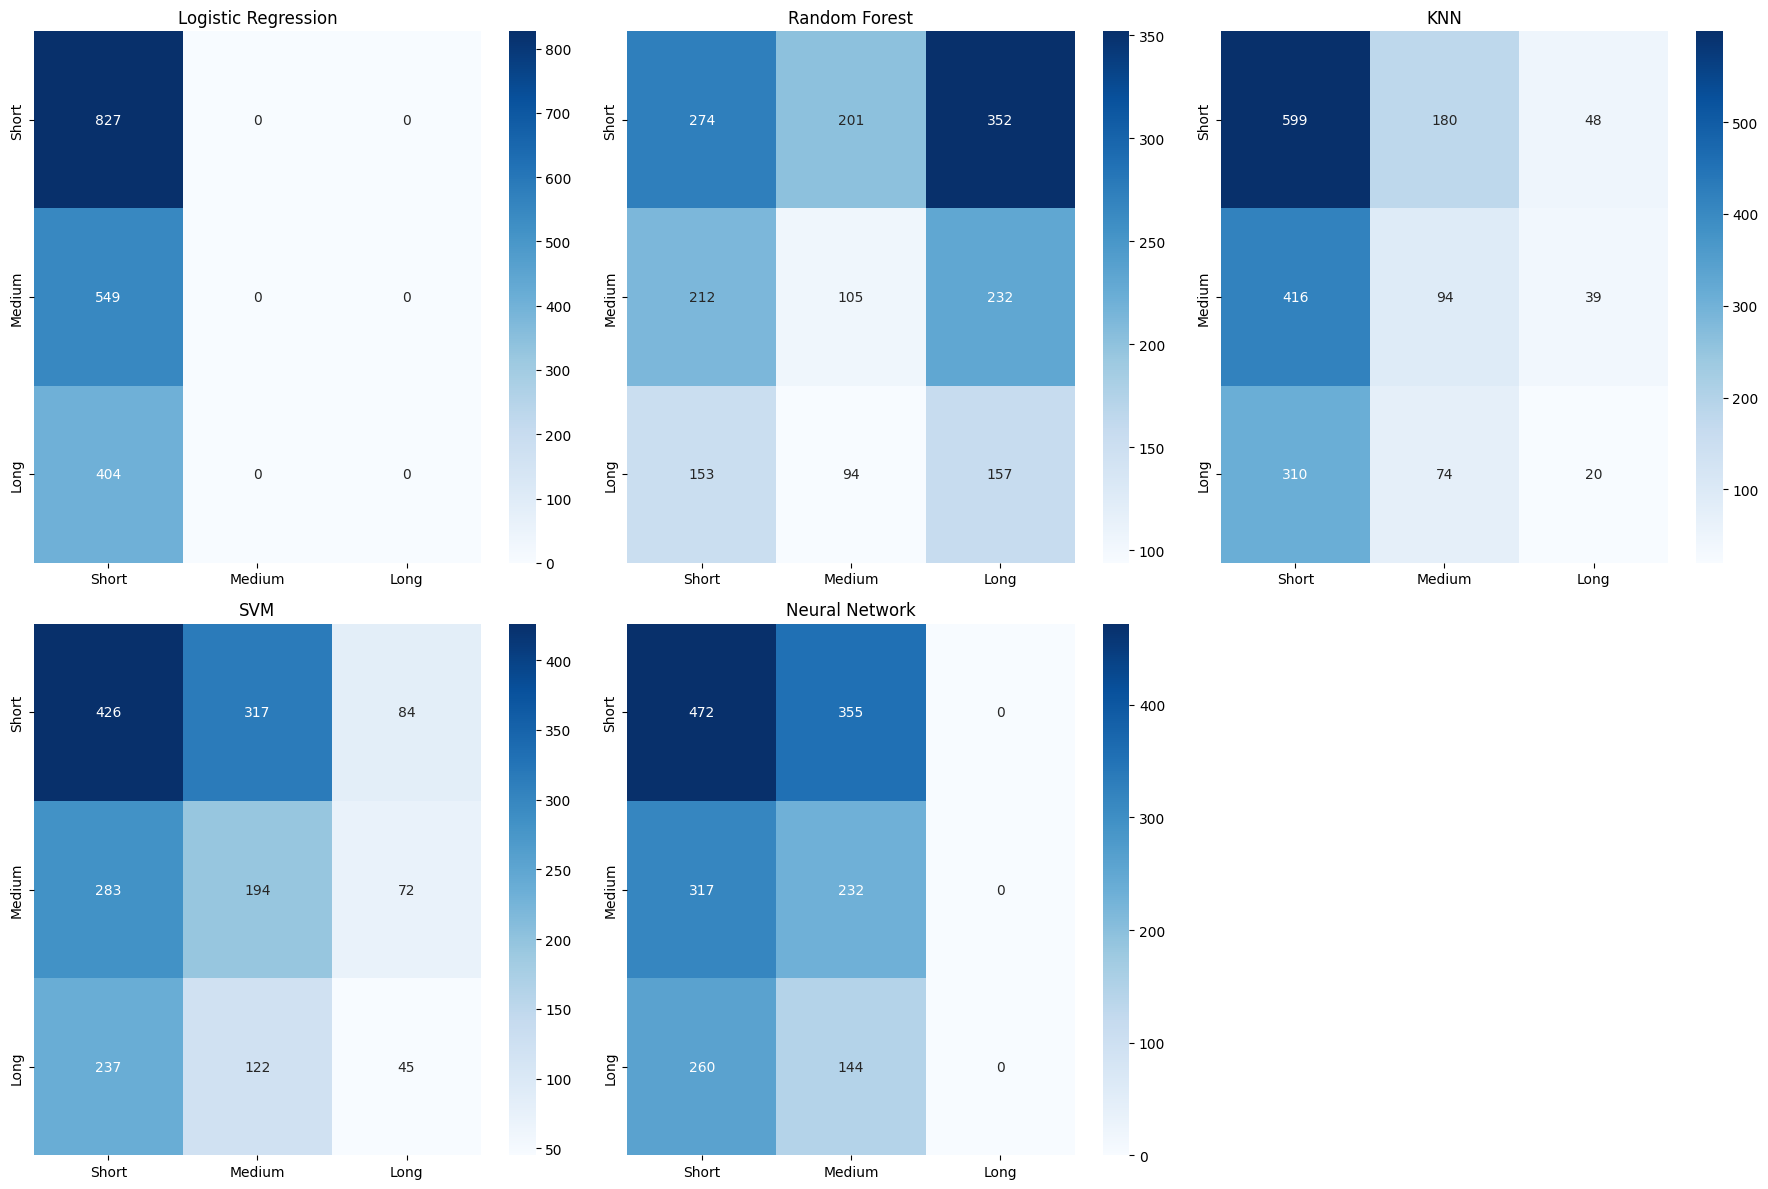

In [ ]:
# %% 

# Plot confusion matrices for each model
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Confusion matrix plots for Logistic Regression, Random Forest, KNN, SVM, and Neural Network
log_confusion_mtx = confusion_matrix(y_test, logistic_best_model.predict(X_test_scaled))
rf_confusion_mtx = confusion_matrix(y_test, rf_best_model.predict(X_test_scaled))
knn_confusion_mtx = confusion_matrix(y_test, knn_best_model.predict(X_test_scaled))
svm_confusion_mtx = confusion_matrix(y_test, svm_best_model.predict(X_test_scaled))
nn_confusion_mtx = confusion_matrix(y_test, improved_neural_model.predict(X_test_scaled).argmax(axis=1))

# Plot each confusion matrix, but remove the last subplot (axes[1, 2])
plots = [
    (log_confusion_mtx, 'Logistic Regression', axes[0, 0]),
    (rf_confusion_mtx, 'Random Forest', axes[0, 1]),
    (knn_confusion_mtx, 'KNN', axes[0, 2]),
    (svm_confusion_mtx, 'SVM', axes[1, 0]),
    (nn_confusion_mtx, 'Neural Network', axes[1, 1])
]

# Plotting each confusion matrix
for conf_mtx, title, ax in plots:
    sns.heatmap(conf_mtx, annot=True, fmt='g', cmap='Blues', ax=ax, xticklabels=class_labels, yticklabels=class_labels)
    ax.set_title(title)

# Hide the last subplot (axes[1, 2])
fig.delaxes(axes[1, 2])  # Remove the empty subplot

plt.tight_layout()
plt.show()

In [ ]:
# %%

### Conmclusions###

# Based on the analysis, the relationship between Unit_Occupancy_Rate_ReleaseDate and Duration_Category appears weak.
# The models (Logistic Regression, Random Forest, KNN, and SVM) show low predictive power, indicating that the occupancy rate at the time of release is not a strong determinant of hospitalization duration (categorized as Short, Medium, or Long).
# This is further supported by the relatively close performance of all models, none of which significantly outperform the others.
# The small number of NaN values and their removal likely didn't have a substantial effect on the model results.
# Overall, the models suggest that other factors may be more influential in determining hospitalization duration than unit occupancy rate alone.
# Further exploration of additional variables is recommended to enhance predictive accuracy.

### Logistic Regression Conclusion
Logistic Regression showed moderate performance but struggled with distinguishing between Medium and Long categories. This suggests that **Unit_Occupancy_Rate_ReleaseDate** alone might not have enough distinguishing power for these classes.

## Results Visualization
After training the models, confusion matrices are generated for each to visually assess their performance. These matrices show how well each model distinguishes between the Short, Medium, and Long hospitalization durations.

## Conclusion
The analysis shows that **Unit_Occupancy_Rate_ReleaseDate** has limited predictive power for hospitalization duration. None of the models, including Logistic Regression, Random Forest, KNN, SVM, and the Neural Network, performed significantly well in distinguishing between the Short, Medium, and Long categories. Random Forest had a slightly better balanced accuracy, but the overall results suggest that additional features or different data preprocessing techniques would be needed to improve prediction accuracy. Further analysis should incorporate more variables, as unit occupancy rate alone is not sufficient for predicting hospitalization duration.

### Random Forest Conclusion
Random Forest provided slightly better performance compared to Logistic Regression, particularly in balancing accuracy across classes. However, it also struggles with making clear distinctions between Medium and Long hospitalization durations.

### K-Nearest Neighbors (KNN) Conclusion
KNN performed weaker than Random Forest and Logistic Regression, indicating that it might not be the best approach for this task. The results suggest that KNN might overfit the training data, and its ability to generalize is limited.

### Support Vector Machine (SVM) Conclusion
SVM shows similar challenges as the other models, with a slight improvement in distinguishing between Short and Long durations. However, it still struggles with the Medium category, suggesting that more features may be needed to improve performance.

### Neural Network Conclusion
The Neural Network performed similarly to the traditional models, with slight improvements in classifying Short durations. However, it still struggles to differentiate well between Medium and Long classes, likely due to the limited feature set.